# 네이버 영화 리뷰 감성 분류하기

모델은 고정해두고   
(1) 데이터 양을 다르게 하고 (절반/전체)   
(2) 전처리를 다르게 해서 (불용어 처리 유무, oov를 전체/일부/최소)  
다양한 전처리 단계를 통해 분석량 변화  

### 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re # 정규 표현식 관련 모델
from konlpy.tag import Okt #Open Korean Text 형태소 분리 모듈
from tqdm import tqdm # 진행 상황을 보여주는 모듈

In [82]:
# 한글 깨짐 방지
import platform

if platform.system() == 'Windows': 
    path = r'c:\Windows\Fonts\gulim.ttf'
elif platform.system() == 'Darwin': # Mac OS
    path = r'/System/Library/Fonts/AppleGothic'
else:
    path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

##### [1] 데이터 로드하기

In [4]:
data = pd.read_table('./data/data.txt')

In [5]:
data.head(20)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


##### [2] 데이터 정제하기

[2 - 1] 정규식을 통한 한글과 공백을 제외한 문자 제거

In [6]:
data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\LJH\AppData\Local\Temp\ipykernel_12832\192973331.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


[2 - 2] 중복 유무 확인

In [7]:
# document열의 중복여부 확인
print('전체 데이터 :', len(data))
print('고유값 :', data['document'].nunique())

전체 데이터 : 150000
고유값 : 143682


전체 데이터에서 고유값과 차이가 난다는 것은 그만큼의 중복값이 있다는 것이니 제거한다

In [8]:
# 중복 데이터 제거
data.drop_duplicates(subset=['document'], inplace = True)

[2 - 3] 결측치 확인

In [9]:
data.isna().sum()

id          0
document    1
label       0
dtype: int64

In [10]:
# 결측 데이터 확인
data.loc[data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [11]:
# 결측치 제거
data = data.dropna(how = 'any')

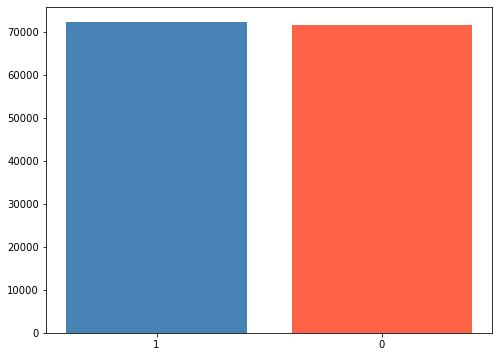

   label  count
0      0  72216
1      1  71466


In [12]:
plt.figure(figsize=(8,6))
plt.bar(['1', '0'], data['label'].value_counts(), color = ['steelblue', 'tomato'])
plt.show()

print(data.groupby('label').size().reset_index(name = 'count'))

거의 같은 데이터 자료로 구성되어 있음

##### [3] 토큰화

[3 - 1] 불용어 제거

https://www.ranks.nl/stopwords/korean

참고) 기본적인 한국어 불용어 리스트 100개
- https://bab2min.tistory.com/544
    * 단, 이 리스트는 구어나 인터넷의 가벼운 글들을 반영하지 않아서 블로그/SNS 등에는 적합하지 않음

**불용어 지정 - 분기 (1)**

In [13]:
with open("./data/stopwords.txt", "r", encoding = "utf-8") as f:
    stopwords = f.readlines()
    stopwords = stopwords[0].split(" ")

In [14]:
print(len(stopwords))
print(stopwords[:20])

889
['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다']


889개의 불용어로 구성되어 있는데 조금 지나치게 많은거 아닌가?

In [15]:
stopwords_01 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

**형태소 분석 - 분기 (2)**

In [17]:
okt = Okt()

In [18]:
# 토큰화만 형태소로 진행된 경우
X_train_00 = []
# 토큰화와 불용어 적게 제거한 경우
X_train_01 = []
# 토큰화와 형태소, 불용어 많이 제거한 경우
X_train_02 = []

# 00
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_train_00.append(tokenized_sentence)

# 01
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_01] # 불용어 적게 제거
    X_train_01.append(stopwords_removed_sentence)

# 02
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 많이 제거
    X_train_02.append(stopwords_removed_sentence)

100%|██████████| 143682/143682 [31:25<00:00, 76.19it/s] 


##### [4] 정수 인코딩

In [20]:
# 각각의 데이터에 대한 Tokenizer 생성
tokenizer_0 = Tokenizer()
tokenizer_1 = Tokenizer()
tokenizer_2 = Tokenizer()
# 각각의 Tokenizer 훈련
tokenizer_0.fit_on_texts(X_train_00)
tokenizer_1.fit_on_texts(X_train_01)
tokenizer_2.fit_on_texts(X_train_02)

In [26]:
print('불용어를 제거하지 않는 경우  :', len(tokenizer_0.word_index))
print('불용어를 일부만 제거한 경우  :', len(tokenizer_1.word_index))
print('불용어를 많이 제거한 경우    :', len(tokenizer_2.word_index))

불용어를 제거하지 않는 경우  : 43770
불용어를 일부만 제거한 경우  : 43752
불용어를 많이 제거한 경우    : 43431


In [69]:
def checkToken(tokenizer, threshold) :
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value
    

    total = (rare_freq / total_freq)*100

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    return (rare_freq / total_freq) * 100

In [76]:
num_pro_0_30 = checkToken(tokenizer_0, 30)
print('------------------------------')
num_pro_0_3 = checkToken(tokenizer_0, 3)
print('------------------------------')
num_pro_1_30 = checkToken(tokenizer_1, 30)
print('------------------------------')
num_pro_1_3 = checkToken(tokenizer_1, 3)
print('------------------------------')
num_pro_2_30 = checkToken(tokenizer_2, 30)
print('------------------------------')
num_pro_2_3 = checkToken(tokenizer_2, 3)

list_pro_30 = []
list_pro_3 = []

list_pro_30.append(num_pro_0_30)
list_pro_30.append(num_pro_1_30)
list_pro_30.append(num_pro_2_30)
list_pro_3.append(num_pro_0_3)
list_pro_3.append(num_pro_1_3)
list_pro_3.append(num_pro_2_3)

단어 집합(vocabulary)의 크기 : 43770
등장 빈도가 30번 미만인 희귀 단어의 수: 39276
단어 집합에서 희귀 단어의 비율: 89.73269362577108
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.339727969798032
------------------------------
단어 집합(vocabulary)의 크기 : 43770
등장 빈도가 3번 미만인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.608864519076995
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5747898974035586
------------------------------
단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 30번 미만인 희귀 단어의 수: 39276
단어 집합에서 희귀 단어의 비율: 89.76961053208996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.933426758471379
------------------------------
단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 3번 미만인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.631742548912044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8757278609673573
------------------------------
단어 집합(vocabulary)의 크기 : 43431
등장 빈도가 30번 미만인 희귀 단어의 수: 39189
단어 집합에서 희귀 단어의 비율: 90.23278303515922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.946876212679722
------------------------------
단어 집합(vocabulary)의 크기 : 43431
등장 빈도가 3번 미만인 희귀 단어의 수: 24307
단어 집합에서 희귀 단어의 비율: 55.966936059496675
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.

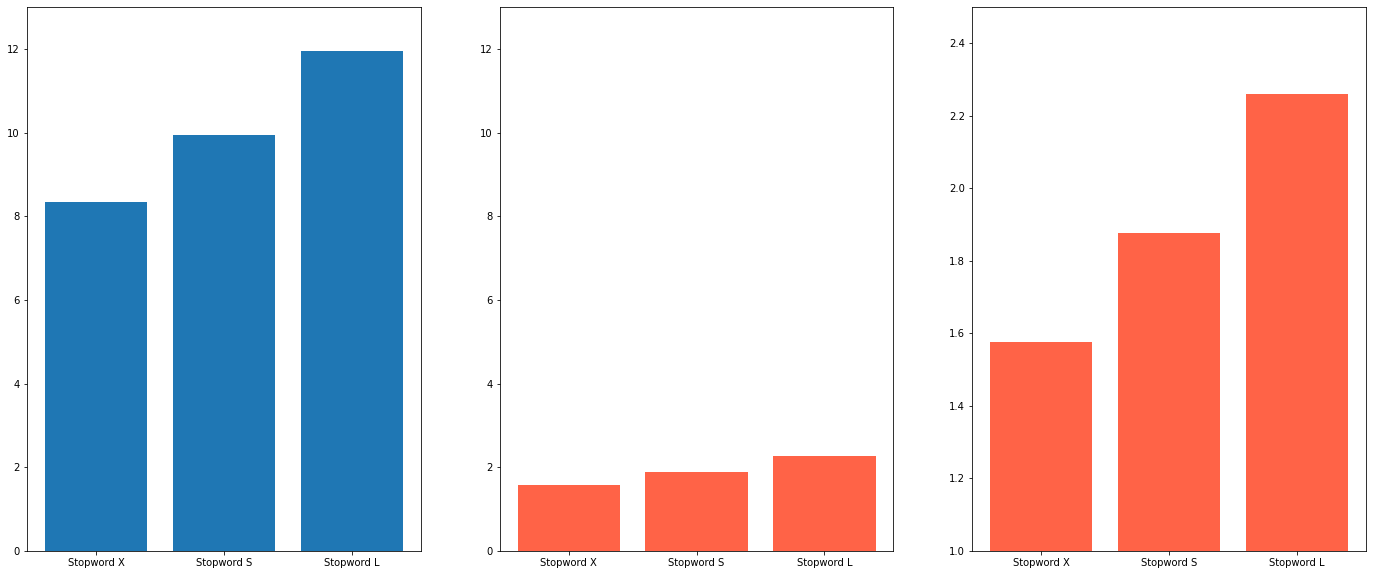

In [138]:
plt.figure(figsize=(24,10))
plt.subplot(131)
plt.bar(['Stopword X', 'Stopword S', 'Stopword L'], list_pro_30)
plt.ylim(0,13)
plt.subplot(132)
plt.bar(['Stopword X', 'Stopword S', 'Stopword L'], list_pro_3, color = 'tomato')
plt.ylim(0,13)
plt.subplot(133)
plt.bar(['Stopword X', 'Stopword S', 'Stopword L'], list_pro_3, color = 'tomato')
plt.ylim(1,2.5)
plt.show()

In [109]:
total_cnt_0 = 43770
total_cnt_1 = 43752
total_cnt_2 = 43431

rare_cnt_0_1  = 39276
rare_cnt_0_2  = 24340

rare_cnt_1_1  = 39189
rare_cnt_1_2  = 24307

vocab_size_0_0 = total_cnt_0 + 1
vocab_size_0_3 = total_cnt_0 - rare_cnt_0_1 + 1
vocab_size_0_30 = total_cnt_0 - rare_cnt_0_2 + 1

vocab_size_1_0 = total_cnt_1 + 1
vocab_size_1_3 = total_cnt_1 - rare_cnt_0_1 + 1
vocab_size_1_30 = total_cnt_1 - rare_cnt_0_2 + 1

vocab_size_2_0 = total_cnt_2 + 1
vocab_size_2_3 = total_cnt_2 - rare_cnt_1_1 + 1
vocab_size_2_30 = total_cnt_2 - rare_cnt_1_2 + 1

print(vocab_size_0_0)
print(vocab_size_0_3)
print(vocab_size_0_30)
print(vocab_size_1_0)
print(vocab_size_1_3)
print(vocab_size_1_30)
print(vocab_size_2_0)
print(vocab_size_2_3)
print(vocab_size_2_30)

43771
4495
19431
43753
4477
19413
43432
4243
19125


텍스트 시퀀스를 정수 시퀀스로 변환

In [110]:
tokenizer_0_0 = Tokenizer(vocab_size_0_0)
tokenizer_0_3 = Tokenizer(vocab_size_0_3)
tokenizer_0_30 = Tokenizer(vocab_size_0_30)
tokenizer_1_0 = Tokenizer(vocab_size_1_0)
tokenizer_1_3 = Tokenizer(vocab_size_1_3)
tokenizer_1_30 = Tokenizer(vocab_size_1_30)
tokenizer_1_0 = Tokenizer(vocab_size_2_0)
tokenizer_1_3 = Tokenizer(vocab_size_2_3)
tokenizer_1_30 = Tokenizer(vocab_size_2_30)

In [113]:
X_train_0_0 = tokenizer_0_0.fit_on_texts(X_train_00)
X_train_0_3 = tokenizer_0_3.fit_on_texts(X_train_00)
X_train_0_30 = tokenizer_0_30.fit_on_texts(X_train_00)
X_train_1_0 = tokenizer_1_0.fit_on_texts(X_train_01)
X_train_1_3 = tokenizer_1_3.fit_on_texts(X_train_01)
X_train_1_30 = tokenizer_1_30.fit_on_texts(X_train_01)
X_train_2_0 = tokenizer_1_0.fit_on_texts(X_train_02)
X_train_2_3 = tokenizer_1_3.fit_on_texts(X_train_02)
X_train_2_30 = tokenizer_1_30.fit_on_texts(X_train_02)

In [114]:
X_train_0_0 = tokenizer_0_0.texts_to_sequences(X_train_00)
X_train_0_3 = tokenizer_0_3.texts_to_sequences(X_train_00)
X_train_0_30 = tokenizer_0_30.texts_to_sequences(X_train_00)
X_train_1_0 = tokenizer_1_0.texts_to_sequences(X_train_01)
X_train_1_3 = tokenizer_1_3.texts_to_sequences(X_train_01)
X_train_1_30 = tokenizer_1_30.texts_to_sequences(X_train_01)
X_train_2_0 = tokenizer_1_0.texts_to_sequences(X_train_02)
X_train_2_3 = tokenizer_1_3.texts_to_sequences(X_train_02)
X_train_2_30 = tokenizer_1_30.texts_to_sequences(X_train_02)

## 여기까지하고 일단 저장해두자...

In [130]:
df = pd.DataFrame([X_train_0_0, X_train_0_3,
X_train_0_30, X_train_1_0, X_train_1_3, X_train_1_30,
X_train_2_0, X_train_2_3, X_train_2_30]).T

In [131]:
df.columns = (['Stopword_X_0', 'Stopword_X_3', 'Stopword_X_30', 'Stopword_S_0', 'Stopword_S_3', 'Stopword_S_30', 'Stopword_L_0', 'Stopword_L_3', 'Stopword_L_30'])

In [132]:
df['label'] = data['label']

In [134]:
df.to_excel(excel_writer='sample.xlsx') #엑셀로 저장